In [1]:
import astropy
from astropy.io import fits
import astropy.units as u
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
from astropy.timeseries import BoxLeastSquares

1. Data Acquisition + Data preprocessing 

In [2]:
fits_files = [
    'tess2018234235059-s0002-0000000100100827-0121-s_lc.fits',
    'tess2018263035959-s0003-0000000100100827-0123-s_lc.fits',
    'tess2020238165205-s0029-0000000100100827-0193-s_lc.fits',
    'tess2020266004630-s0030-0000000100100827-0195-s_lc.fits',
    'tess2023237165326-s0069-0000000100100827-0264-s_lc.fits'
]

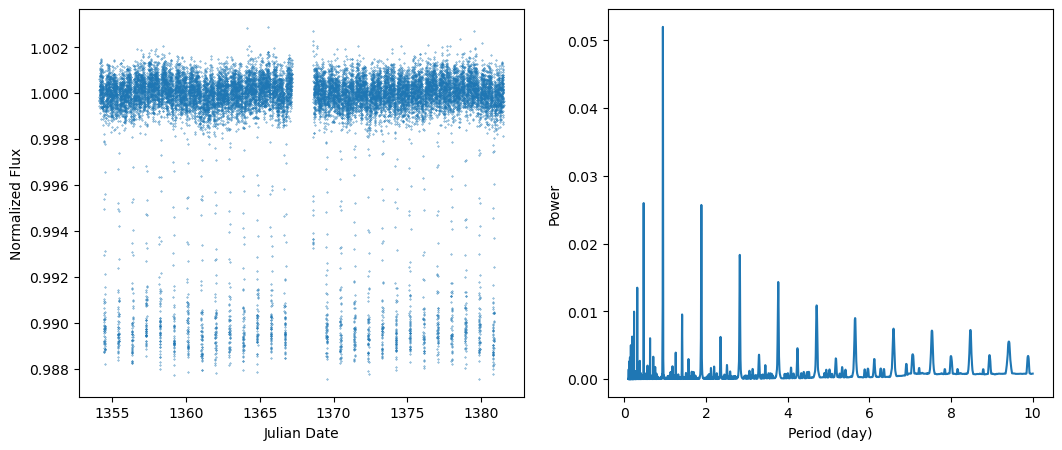

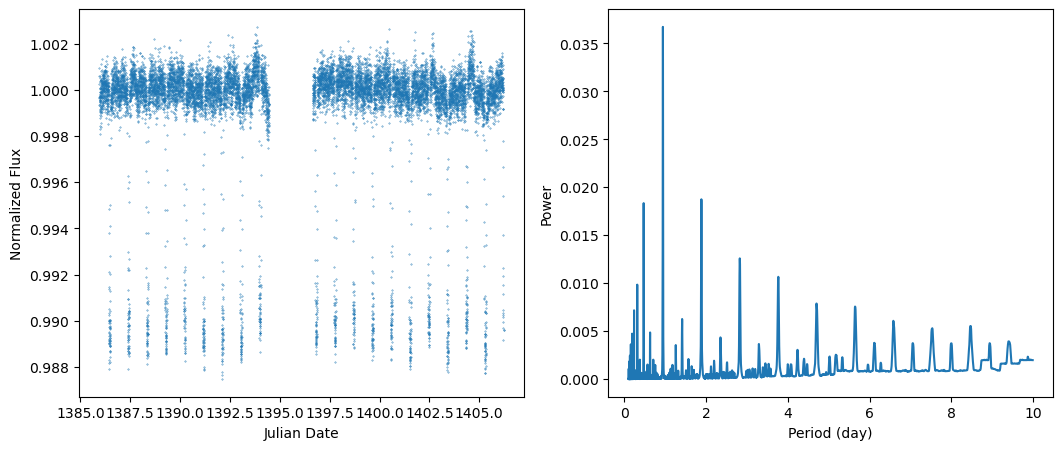

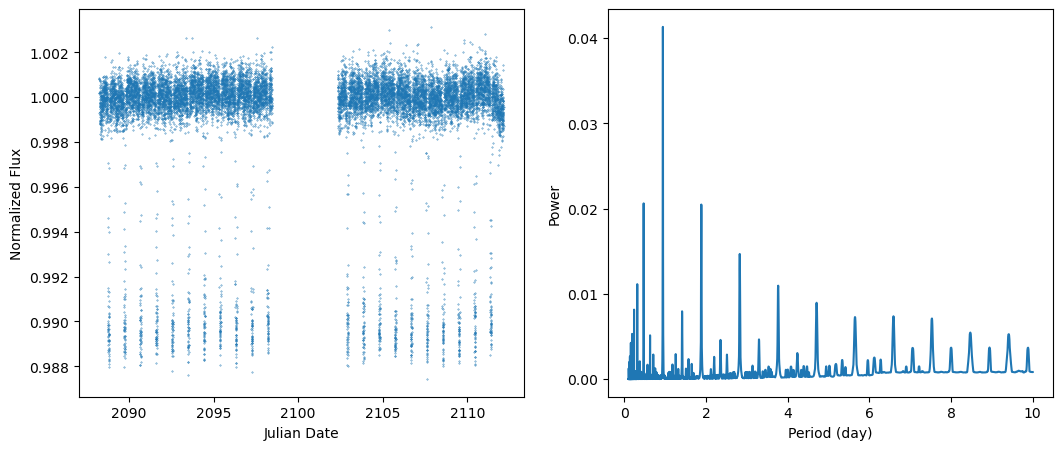

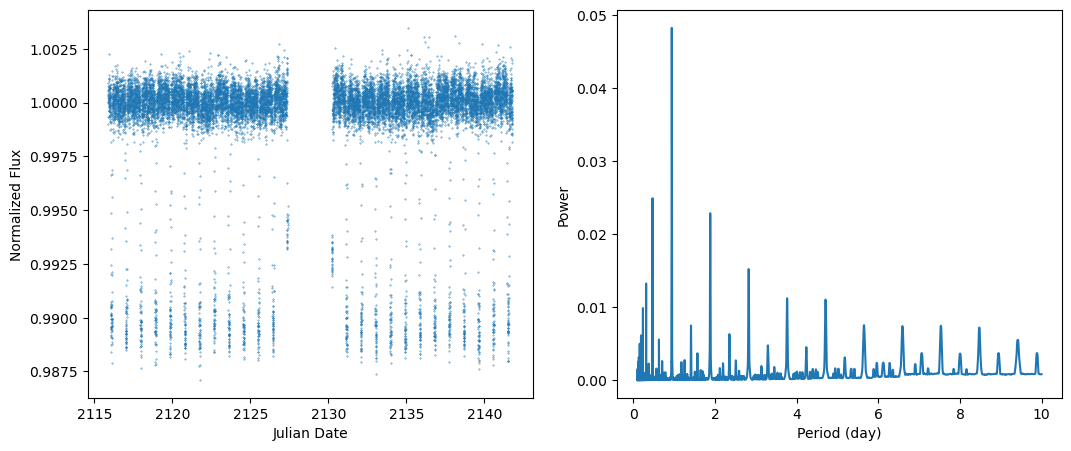

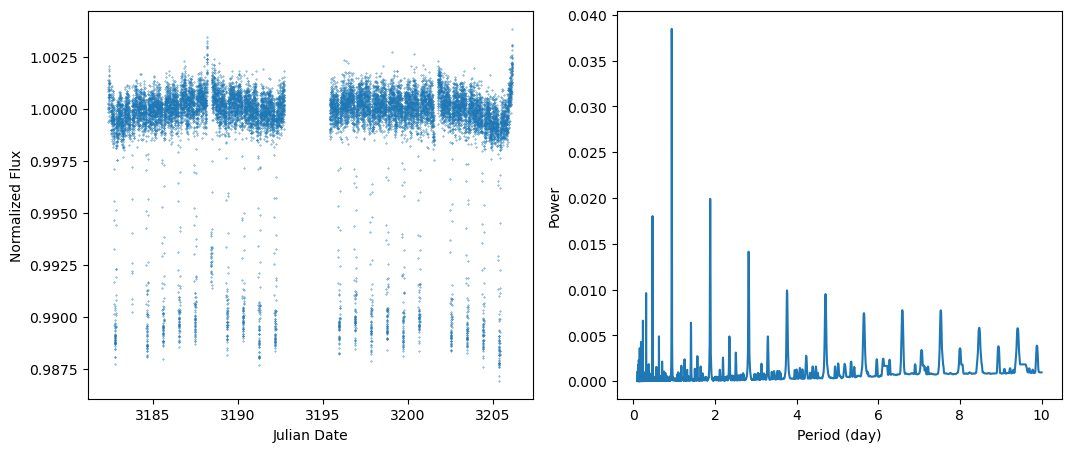

Average flux error:  1.0


In [3]:
# Lists to store flux and time data
all_flux = []
all_time = []
transit_depth_ls = []
transit_duration_ls = []
transit_period_ls = []
transit_depth_err_ls = []
epoch = []
phase_ls = []
time_shifted = []
flux_err = []
for i, fits_file in enumerate(fits_files):
    hdu_list = fits.open(fits_file, memmap=True)
    data = Table(hdu_list[1].data)

    # Clean data
    mask = (data['QUALITY'] == 0) & (~np.isnan(data['PDCSAP_FLUX']))
    data_filtered = data[mask]

    # Append time and flux to the respective lists
    current_time = data_filtered['TIME'].tolist()
    current_flux = data_filtered['PDCSAP_FLUX']/(np.median(data_filtered['PDCSAP_FLUX'])).tolist()
    current_flux_error = data_filtered['PDCSAP_FLUX_ERR']/(np.median(data_filtered['PDCSAP_FLUX_ERR'])).tolist()
    flux_err.extend(current_flux_error)
    all_time.extend(current_time)
    all_flux.extend(current_flux)

    # Plotting code
    figure, ax = plt.subplots(1, 2)
    figure.set_figwidth(11)
    figure.set_figheight(5)
    figure.tight_layout(pad=3.0)

    plt.subplot(1, 2, 2)
    model = BoxLeastSquares(np.array(current_time) * u.day, np.array(current_flux), dy= np.array(current_flux_error))
    periodogram = model.autopower(0.05 * u.day, minimum_period=0.1, maximum_period=10, oversample=1000)
    max_power = np.argmax(periodogram.power)
    transit_period_ls.append(periodogram.period[max_power].value)
    transit_depth_ls.append(periodogram.depth[max_power])
    transit_duration_ls.append(periodogram.duration[max_power].value)  
    epoch.append(periodogram.transit_time[max_power].value)
    transit_time = periodogram.transit_time[max_power].value
    period = periodogram.period[max_power].value
    stats = model.compute_stats(periodogram.period[max_power],
                            periodogram.duration[max_power],
                            periodogram.transit_time[max_power])
    transit_depth_err_ls.append(stats['depth'][1])
    
    
    plt.plot(periodogram.period, periodogram.power)
     
    plt.xlabel('Period (day)')
    plt.ylabel('Power')
   # plt.title(f'{fits_file}')
    plt.subplot(1, 2, 1)
    plt.scatter(current_time, current_flux, s = 0.1)
    plt.xlabel('Julian Date')
    plt.ylabel('Normalized Flux')
    plt.savefig('./images/lc_' + str(i)+ '.png')
    plt.show()
flux_err_avg = np.median(flux_err)
print('Average flux error: ' , flux_err_avg)
# Create a table from the concatenated data
result_table = Table({'TIME': all_time, 'FLUX': all_flux})


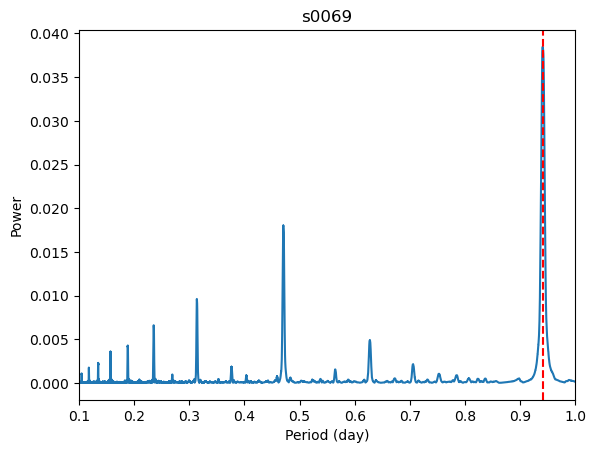

In [5]:
#repeat procedure for file #1 to zoom in on the large spike that shows the period: 
hdu_list = fits.open('tess2018234235059-s0002-0000000100100827-0121-s_lc.fits', memmap=True)
data = Table(hdu_list[1].data)
for i in range(len(data)): 
    new_flux = []
    new_time = []
    new_flux_err = []
    if(data['QUALITY'][i] == 0 and ~np.isnan(data['PDCSAP_FLUX'][i])): 
        new_flux.append(data['PDCSAP_FLUX'][i])
        new_time.append(data['TIME'][i])

model = BoxLeastSquares(np.array(current_time) * u.day, np.array(current_flux), dy=np.array(current_flux_error))
periodogram = model.autopower(0.05 * u.day, minimum_period=0.1, maximum_period=10, oversample=1000)
max_power = np.argmax(periodogram.power)  
stats = model.compute_stats(periodogram.period[max_power],
                            periodogram.duration[max_power],
                            periodogram.transit_time[max_power])
plt.plot(periodogram.period, periodogram.power, label = 'Periodogram')
plt.title('s0069')
plt.xlabel('Period (day)')
plt.ylabel('Power')
plt.xlim(0.1, 1)
plt.axvline(x=0.941, color='red', linestyle='--', label='Period of 0.94 days')
plt.savefig('./images/period_4.png')

Concatinate lightcurve and produce concatinated periodogram

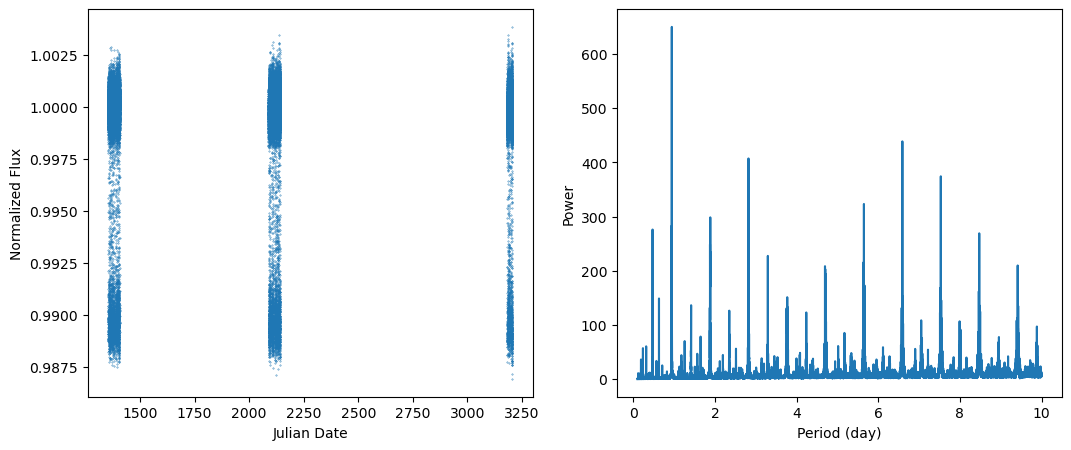

In [6]:
concate_time = np.array([])
concate_flux = np.array([]) 
for i in range(5): 
    data_file = fits.open(fits_files[i], memmap=True)
    time = data_file[1].data['TIME']
    flux = data_file[1].data['PDCSAP_FLUX']
    quality = data_file[1].data['QUALITY']
    new_flux = np.array([])
    new_time = np.array([])
    for j in range(len(time)):
        if(quality[j] == 0 and np.isnan(flux[j]) == False):
            new_flux = np.append(new_flux, flux[j])
            new_time = np.append(new_time, time[j])
    flux_med = np.median(new_flux)
    if(flux_med == 0 or np.isnan(flux_med) == True):
        print(flux_med)
    new_flux = new_flux/flux_med
    concate_time = np.append(concate_time, new_time)
    concate_flux = np.append(concate_flux, new_flux)
model = BoxLeastSquares(concate_time * u.day, concate_flux, dy=0.01)
period = np.linspace(0.1, 10, 10000) *u.day
periodogram = model.power(period, 0.08)
figure, ax = plt.subplots(1, 2)
figure.set_figwidth(11)
figure.set_figheight(5)
figure.tight_layout(pad=3.0)
plt.subplot(1, 2, 2)
plt.plot(periodogram.period,periodogram.power)
plt.xlabel('Period (day)')
plt.ylabel('Power')
plt.subplot(1, 2, 1)
plt.scatter(concate_time, concate_flux, s=0.1)
plt.xlabel('Julian Date')
plt.ylabel('Normalized Flux')
max_power = np.argmax(periodogram.power)
transitperiod = periodogram.period[max_power].value
transitdepth = periodogram.depth[max_power]
transittime = periodogram.transit_time[max_power].value
transitduration = periodogram.duration[max_power].value
plt.savefig('./images/concate_lc.png')




In [7]:
result_table

TIME,FLUX
float64,float32
1354.1115072617192,0.99984264
1354.1128961919705,1.0006068
1354.1142851224547,0.99966145
1354.117062983188,0.9997162
1354.1184519134392,1.0001388
1354.1198408439234,0.9994658
1354.1212297741743,0.99980354
1354.1226187044247,1.000062
1354.1240076349084,0.9996107


Calculating statistics

In [8]:
transit_depth = 0
transit_duration = 0
transit_period = 0 
transit_time = 0
transit_depth_err = 0
for i in range(len(transit_depth_ls)): 
    transit_depth = transit_depth + transit_depth_ls[i]
    transit_duration = transit_duration + transit_duration_ls[i]
    transit_period = transit_period + transit_period_ls[i]
    transit_time = transit_time + epoch[i]
    transit_depth_err = transit_depth_err + transit_depth_err_ls[i]
transit_depth = transit_depth/len(transit_depth_ls)
transit_duration = transit_duration/len(transit_duration_ls)
transit_period = transit_period/len(transit_period_ls)
transit_time = transit_time/len(epoch)
transit_depth_err = transit_depth_err/len(transit_depth_err_ls)
transit_duration_err = 1/transit_duration
transit_period_err = 1/transit_period
transit_time_err = 1/transit_time
print('transit depth: ', transit_depth, '+/-' , transit_depth_err, '\n', 'transit duration: ', transit_duration,  '+/- ', 1/transit_duration,  '\n', 'transit period: ', transit_period,  '+/- ', 1/transit_period, '\n', 'transit time: ', transit_time,  '+/- ' , 1/transit_time)

transit depth:  0.010387759975312773 +/- 0.03648163637821127 
 transit duration:  0.05 +/-  20.0 
 transit period:  0.9413264300046672 +/-  1.0623307368465602 
 transit time:  2025.7145158390624 +/-  0.0004936529763601928


Radius and impact factor calculations

In [9]:
Rs = 1.319 * u.Rsun #stellar radius
Rs_err = 0.0615 * u.Rsun #stellar radius error
radius_planet = np.sqrt(transit_depth) * Rs
radius_planet_err_radiusp = np.sqrt((0.5 * transit_depth_err/transit_depth)**2 + (Rs_err/Rs)**2)
radius_planet_err = radius_planet * radius_planet_err_radiusp
print('radius of planet: ', radius_planet.to(u.Rearth), '+/-', radius_planet_err.to(u.Rearth))

radius of planet:  14.663458953299353 earthRad +/- 25.757984687312813 earthRad


In [10]:
#calculating impact parameter 
aRs = 3.48 #ratio of semi-major axis to stellar radius
aRs_err = 0.0003 #avg of error boundaries
a = (aRs * Rs)
a_err_a = np.sqrt(((aRs_err/aRs)**2 + (Rs_err/Rs)**2))
a_err = a * a_err_a
#find angle of inclination w/ degree of freedom
cosi = (transit_duration *np.pi)/transit_period - (radius_planet.to(u.solRad) + Rs)/a 
cosi_err1= ((transit_duration * np.pi)/(transit_period))*np.sqrt((transit_duration_err/transit_duration)**2 + (transit_period_err/transit_period)**2)
cosi_err2 = np.sqrt(radius_planet_err.to(u.solRad)**2 + Rs_err**2)
x = (radius_planet.to(u.solRad) + Rs)
cosi_err3 = ((radius_planet.to(u.solRad) + Rs)/a)* np.sqrt((cosi_err2/x)**2 + (a_err/a)**2)
cosi_err = np.sqrt(cosi_err1**2 + cosi_err3**2)
print('a: ', a.to(u.AU), '+/-', a_err.to(u.AU))
print('cosi: ', cosi, '+/-', cosi_err)
b = (a*cosi)/Rs
b_err_num = (a*cosi)* np.sqrt((a_err/a)**2 + (cosi_err/cosi)**2)
num = (a*cosi)
b_err = b = (a*cosi)/Rs * np.sqrt((b_err_num/num) **2 + (Rs_err/Rs)**2)
# b_err_num = np.sqrt(((a.to(u.Rsun))*cosi)**2 * (a_err/a)**2 + (cosi_err/cosi)**2)
# b_err = np.sqrt(b**2 * (b_err_num/a.to(u.Rsun)*cosi)**2 + (Rs_err/Rs)**2)
print('impact parameter: ', np.abs(b), '+/-', b_err)

a:  0.021346202783887616 AU +/- 0.0009952947043464317 AU
cosi:  -0.14977325995297455 +/- 66.74849723604231
impact parameter:  232.28477292396667 +/- -232.28477292396667


3. Phase folding (across 3 transits)

In [11]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [12]:
x = 3*transit_period + epoch[0] - 0.5*transit_period
x = float(x)
time_shifted = []
lower_bound = find_nearest(np.array(result_table['TIME']), epoch[0] - 0.5*transit_period)
upper_bound = find_nearest(np.array(result_table['TIME']), x)


In [13]:
trimmed_time = []
trimmed_flux = []
for i in range(len(result_table)): 
    if(result_table['TIME'][i] >= lower_bound and result_table['TIME'][i] <= upper_bound): 
        trimmed_time.append(result_table['TIME'][i])
        trimmed_flux.append(result_table['FLUX'][i])

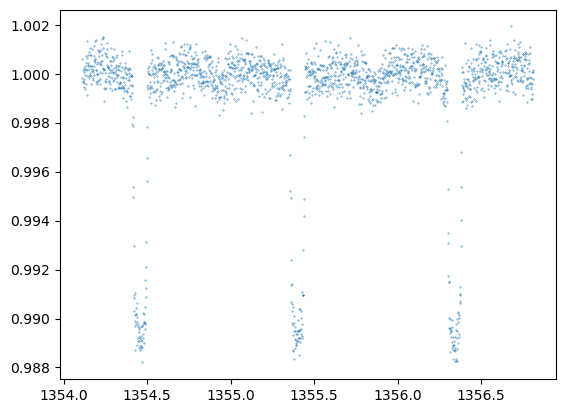

In [14]:
plt.scatter(trimmed_time, trimmed_flux, s=0.1)
plt.savefig('./images/trimmed_lc.png')

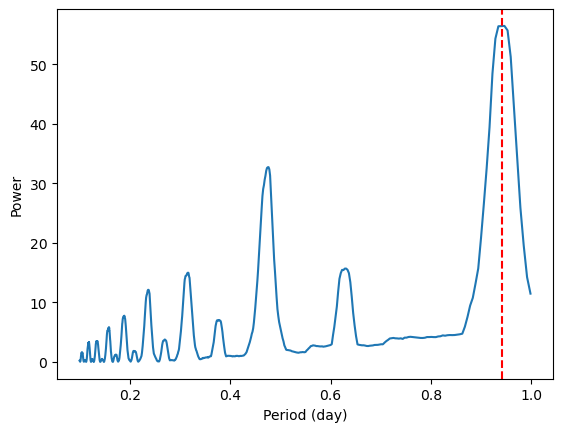

In [15]:
model = BoxLeastSquares(np.array(trimmed_time) * u.day, np.array(trimmed_flux), dy=0.01)
periodogram = model.autopower(0.05 * u.day, minimum_period=0.1, maximum_period=1.0, oversample=1000)
max_power = np.argmax(periodogram.power)
period = periodogram.period[max_power].value
depth = periodogram.depth[max_power]
duration = periodogram.duration[max_power].value 
epoch = periodogram.transit_time[max_power].value
plt.plot(periodogram.period, periodogram.power)
plt.xlabel('Period (day)')
plt.ylabel('Power')
plt.axvline(x=0.941, color='red', linestyle='--', label='Period of 0.94 days')
plt.savefig('./images/3_period_periodogram.png')

In [16]:
phase_LS = []
for i in range(len(trimmed_time)): 
    phase = np.mod((trimmed_time[i] - epoch),0.94145223)
    phase_LS.append(phase)
val = (0.94145223 - epoch)/0.94145223 % 1

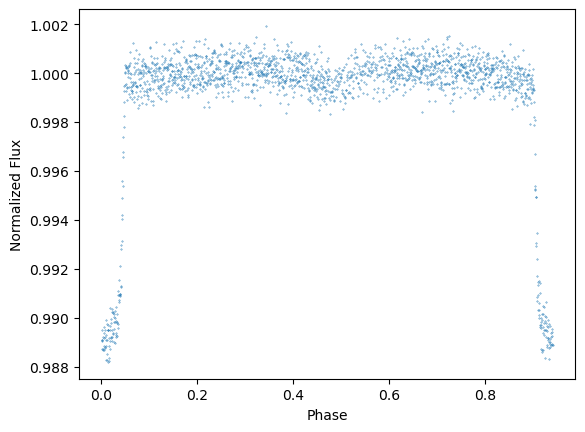

In [17]:
plt.scatter(phase_LS, trimmed_flux, s=0.1)
plt.xlabel('Phase')
plt.ylabel('Normalized Flux')
plt.savefig('Phase_fold_LC_3')

In [41]:
phase_LS = []
for i in range(len(trimmed_time)): 
    #phase[i] = np.mod((concate_time[i] - 2116.0930)-0.94145223/2,0.94145223)
    # used online data.
    phase_LS.append(np.mod((trimmed_time[i] - epoch)-0.94145223/2, 0.94145223))


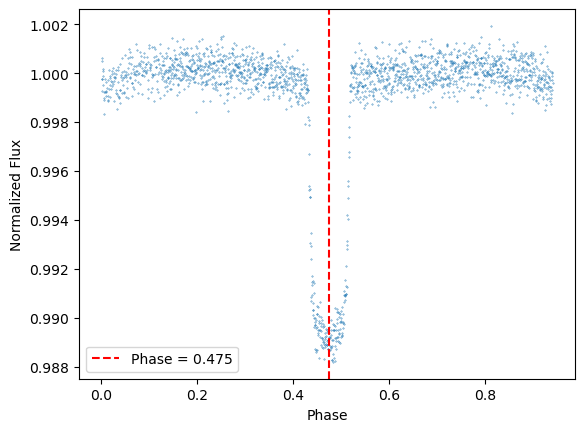

In [43]:
plt.scatter(phase_LS, trimmed_flux, s=0.1)
plt.xlabel('Phase')
plt.ylabel('Normalized Flux')
plt.savefig('Phase_fold_LC_3_centered')
plt.axvline(x=0.475, color='red', linestyle='--', label='Phase = 0.475')
plt.legend()

Phase fold across all transits

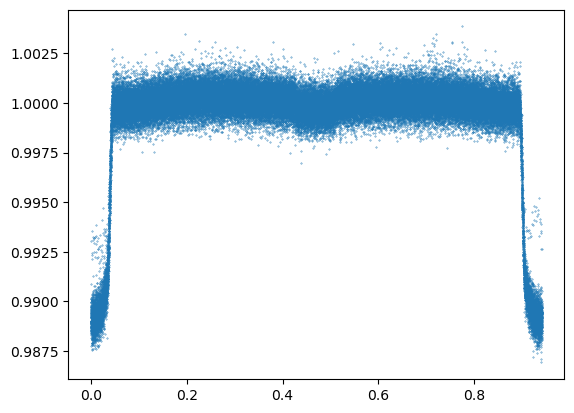

In [44]:
plt.scatter(result_table['PHASE'], result_table['FLUX'], s=0.1)

In [60]:
phase_LS = []
for i in range(len(result_table['TIME'])): 
    #phase[i] = np.mod((concate_time[i] - 2116.0930)-0.94145223/2,0.94145223)
    # used online data.
    phase_LS.append(np.mod((result_table['TIME'][i] + 0.25 - epoch)-0.94145223/2, 0.94145223))
result_table['PHASE'] = phase_LS

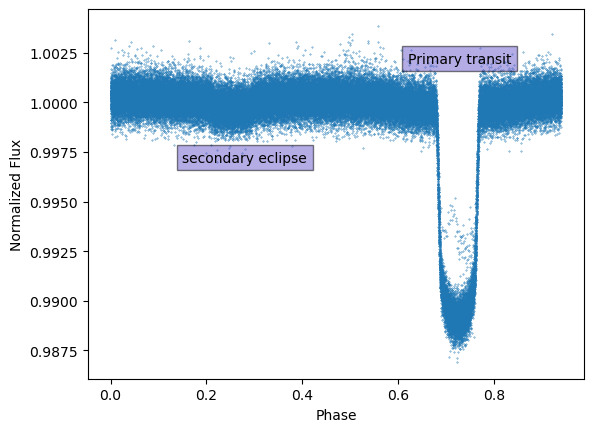

In [94]:
plt.scatter(result_table['PHASE'], result_table['FLUX'], s=0.1)
plt.text(0.15,0.997, "secondary eclipse", bbox=dict(facecolor='slateblue', alpha=0.5))
plt.text(0.62,1.002, "Primary transit", bbox=dict(facecolor='slateblue', alpha=0.5))
plt.xlabel('Phase')
plt.ylabel('Normalized Flux')
plt.savefig('Full_phase_fold')

In [56]:
phase_LS = []
for i in range(len(result_table)): 
    phase = np.mod((result_table['TIME'][i] - transit_time),0.94145223)
    phase_LS.append(phase)
result_table['PHASE'] = phase_LS

In [22]:
sec_time = np.array([])
sec_flux = np.array([])
for i in range(len(concate_time)):
    phase_shift = np.mod((concate_time[i] - transit_time)-0.94145223/2, 0.94145223)
    if phase_shift<0.1 or phase_shift > 0.85:
        sec_time = np.append(sec_time,concate_time[i])
        sec_flux = np.append(sec_flux,concate_flux[i])
model = BoxLeastSquares(sec_time*u.day, sec_flux, dy=0.01)
period = np.linspace(0.1,10,10000)*u.day
periodogram = model.power(period,0.08)
max_power = np.argmax(periodogram.power)
sec_period =periodogram.period[max_power]
sec_transit_time = periodogram.transit_time[max_power]
sec_depth = periodogram.depth[max_power]
stats = model.compute_stats(periodogram.period[max_power],
                            periodogram.duration[max_power],
                            periodogram.transit_time[max_power])
sec_depth_err = stats['depth'][1]


In [23]:
sec_depth

0.00018388933147037238

In [39]:
Rs = 1.319
Rs_err = Rs_err.value
Ls = 10**0.428
Ls_err = 10**0.0435
radius = radius_planet.value 
Ts = 6432
Ts_err = 48
temp = (sec_depth*(Rs/radius)**2 *Ls)**(1/4) * Ts
error = Rs/radius * (np.sqrt((Rs_err/Rs)**2 + (radius_planet_err.value/radius)**2))
error = sec_depth * (Rs/radius)**2 * Ls * (np.sqrt((sec_depth_err/sec_depth)**2 + (2*error/(Rs/radius))**2 + (Ls_err/Ls)**2))
error = temp * np.sqrt((0.25*error/((sec_depth*(Rs/radius)**2 *Ls)**(1/4)))**2 + (Ts_err/Ts)**2)
print('temp: ', temp, '+/-', error)

temp:  3001.6129659573453 +/- 282.1659620794056


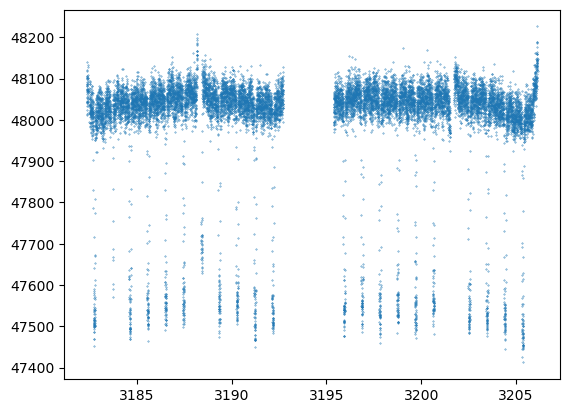

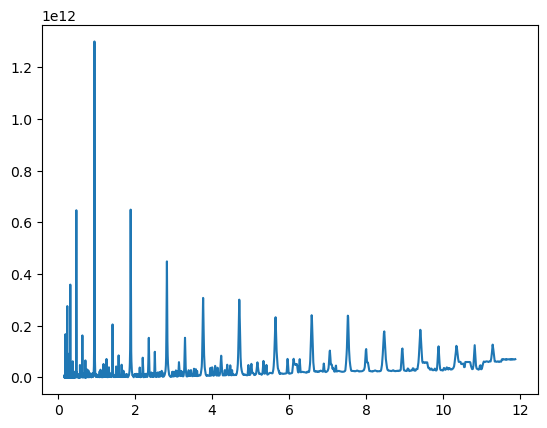

In [25]:
hdu_list= fits.open('tess2023237165326-s0069-0000000100100827-0264-s_lc.fits',memmap=True)
data = Table(hdu_list[1].data)
new_time = []
new_flux = []
for i in range(len(data)): 
    if(data['QUALITY'][i] == 0 and np.isnan(data['PDCSAP_FLUX'][i]) == False): 
        new_time.append(data['TIME'][i])
        new_flux.append(data['PDCSAP_FLUX'][i])
model = BoxLeastSquares(new_time* u.day, new_flux, dy=0.01)
periodogram = model.autopower(0.08*u.day)
epoch = periodogram.transit_time[np.argmax(periodogram.power)].value
period = periodogram.period[np.argmax(periodogram.power)].value 
for i in range(len(new_time))
plt.scatter(new_time, new_flux, s=0.1)
plt.show()
plt.plot(periodogram.period, periodogram.power)
# trimmed_time = []
# trimmed_flux = []
# for i in range(len(new_time)): 
#     if(new_time[i] >= epoch+0.045 and new_time[i] <= epoch+ period):
#         trimmed_time.append(new_time[i])
#         trimmed_flux.append(new_flux[i])

# #plt.scatter(new_time, new_flux, s=0.1)  
# plt.scatter(trimmed_time, trimmed_flux, s=0.1)
# plt.show()
# model = BoxLeastSquares(trimmed_time* u.day, trimmed_time, dy=0.01)
# periodogram = model.autopower(0.08*u.day)
# epoch = periodogram.transit_time[np.argmax(periodogram.power)].value
# period = periodogram.period[np.argmax(periodogram.power)].value 
# depth = periodogram.depth[np.argmax(periodogram.power)]
# plt.plot(periodogram.period, periodogram.power)
# plt.show()
# print('depth: ', depth)


Full phase curve

In [27]:
phase_LS = []
for i in range(len(result_table)): 
    phase = np.mod((result_table['TIME'][i] - transit_time),0.94145223)
    phase_LS.append(phase)
result_table['PHASE'] = phase_LS

Text(0, 0.5, 'Normalized Flux')

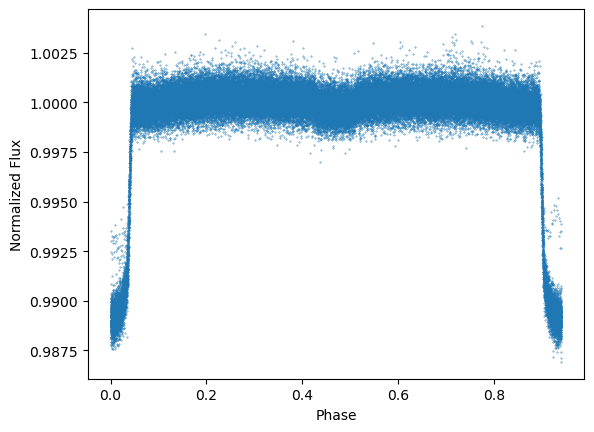

In [28]:
plt.scatter(result_table['PHASE'], result_table['FLUX'], s = 0.1)
plt.xlabel('Phase')
plt.ylabel('Normalized Flux')

In [29]:
phase = np.zeros(len(result_table['TIME']))
for i in range(len(result_table['TIME'])): 
    #phase[i] = np.mod((concate_time[i] - 2116.0930)-0.94145223/2,0.94145223)
    # used online data.
    phase[i] = np.mod((result_table['TIME'][i] - 2116.0930)-0.94145223/2, 0.94145223)
    result_table['PHASE'][i] = phase[i]

In [30]:
trimmed_flux = []
trimmed_time = []
for i in range(len(result_table['TIME'])): 
    if(result_table['PHASE'][i] < 0.1 or result_table['PHASE'][i] > 0.85): 
        trimmed_flux.append(result_table['FLUX'][i])
        trimmed_time.append(result_table['PHASE'][i])
        

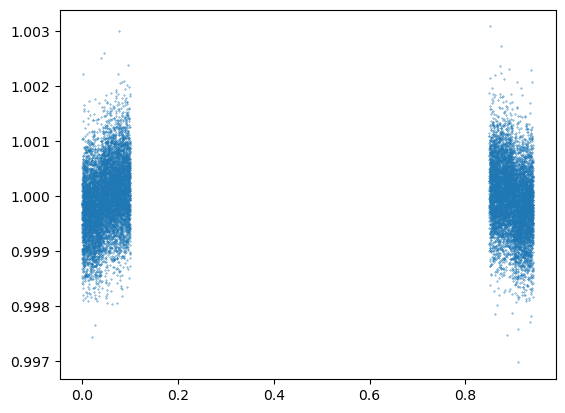

In [31]:
plt.scatter(trimmed_time, trimmed_flux, s=0.1)

AttributeError: 'numpy.float64' object has no attribute 'append'

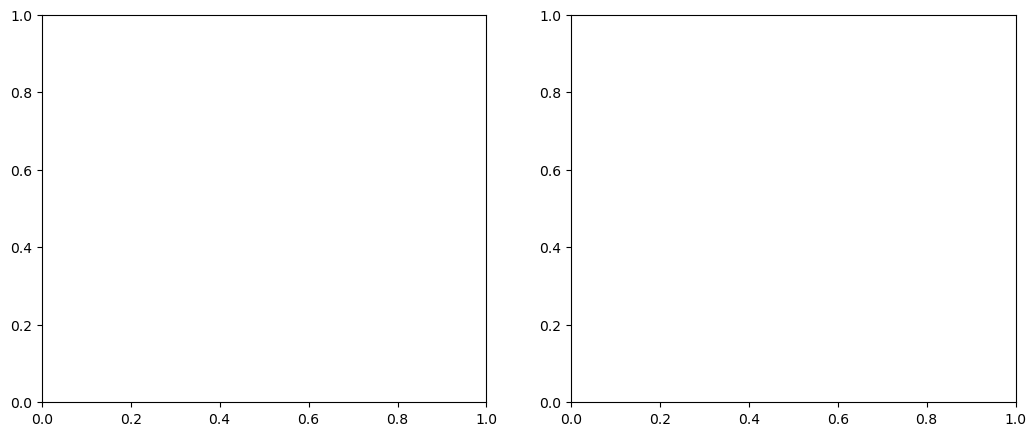

In [32]:
figure, ax = plt.subplots(1, 2)
figure.set_figwidth(11)
figure.set_figheight(5)
figure.tight_layout(pad=3.0)

plt.subplot(1, 2, 2)
model = BoxLeastSquares(np.array(trimmed_time) * u.day, np.array(trimmed_flux), dy=0.01)
periodogram = model.autopower(0.05 * u.day, minimum_period=0.1, maximum_period=10, oversample=1000)
max_power = np.argmax(periodogram.power)
transit_period_ls.append(periodogram.period[max_power].value)
transit_depth_ls.append(periodogram.depth[max_power])
transit_duration_ls.append(periodogram.duration[max_power].value)  
epoch.append(periodogram.transit_time[max_power].value)
transit_time = periodogram.transit_time[max_power].value
period = periodogram.period[max_power].value
plt.plot(periodogram.period, periodogram.power)
     
plt.xlabel('Period (day)')
plt.ylabel('Power')
plt.subplot(1, 2, 1)
plt.scatter(trimmed_time, trimmed_flux, s=0.1)
plt.xlabel('Julian Date')
plt.ylabel('Normalized Flux')


Text(0, 0.5, 'Normalized Flux')

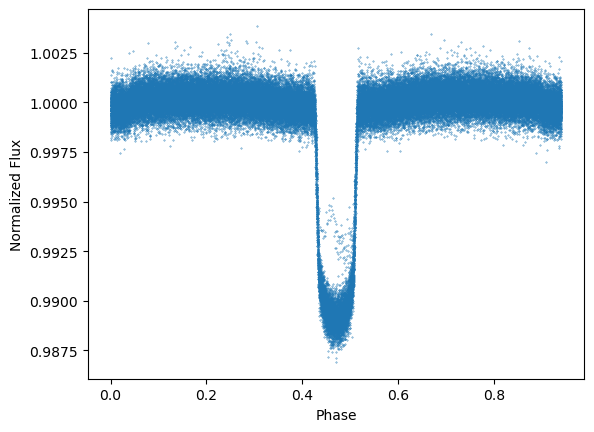

In [33]:
plt.scatter(phase, result_table['FLUX'], s = 0.1)
plt.xlabel('Phase')
plt.ylabel('Normalized Flux')

In [34]:
phase_shift = []
for i in range(len(result_table)): 
    phase = np.mod((result_table['TIME'][i] - transit_time) + 0.2 ,0.94145223)
    phase_shift.append(phase)

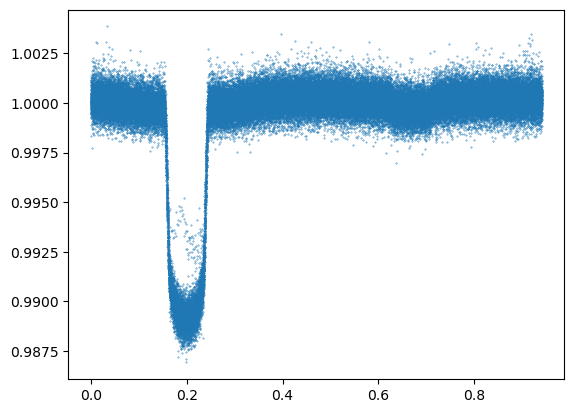

In [35]:
plt.scatter(phase_shift, result_table['FLUX'], s = 0.1)

4. Secondary eclipse 

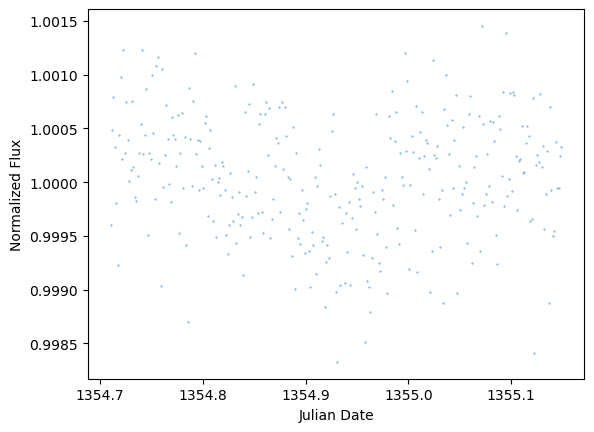

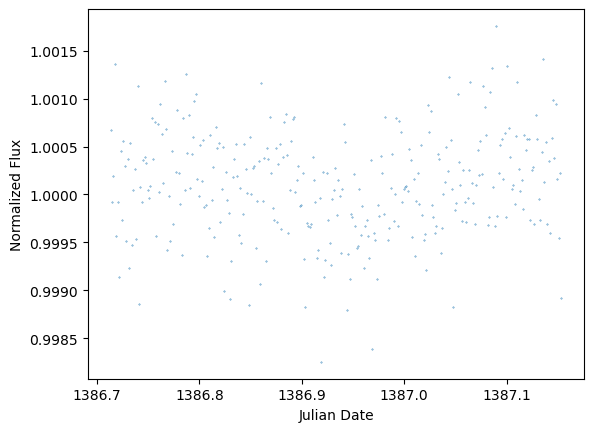

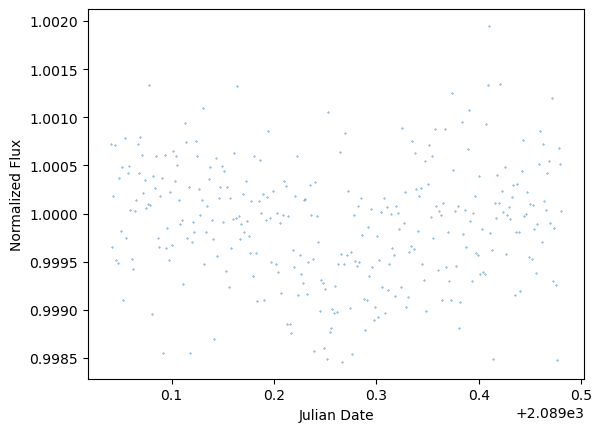

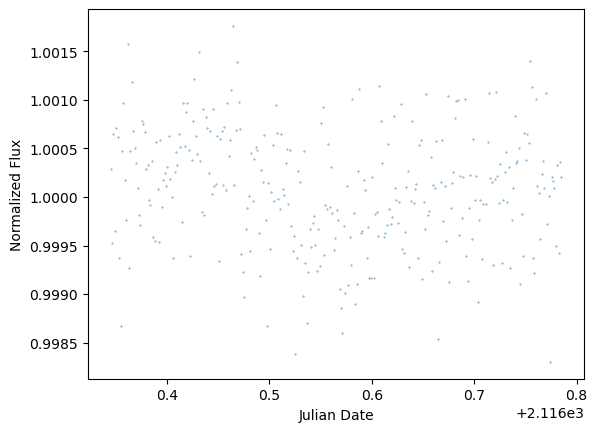

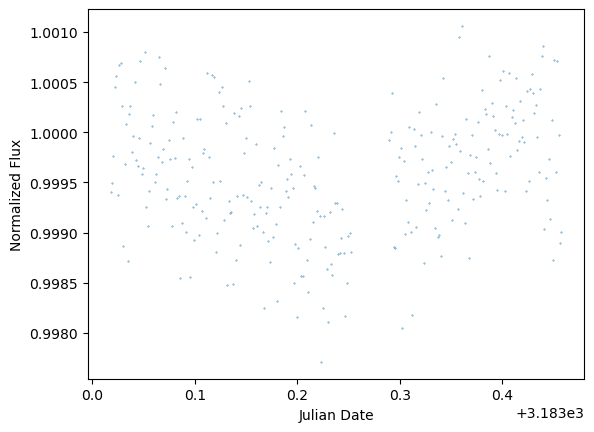

In [22]:
all_flux = []
all_time = []
second_depth = []
period2_ls = []
for i, fits_file in enumerate(fits_files):
    hdu_list = fits.open(fits_file, memmap=True)
    data = Table(hdu_list[1].data)

    # Clean data
    mask = (data['QUALITY'] == 0) & (~np.isnan(data['PDCSAP_FLUX']))
    data_filtered = data[mask]

    # Append time and flux to the respective lists
    current_time = data_filtered['TIME'].tolist()
    current_flux = data_filtered['PDCSAP_FLUX']/(np.median(data_filtered['PDCSAP_FLUX'])).tolist()
    all_time.extend(current_time)
    all_flux.extend(current_flux)
    model = BoxLeastSquares(np.array(current_time) * u.day, np.array(current_flux), dy=0.01)
    periodogram = model.autopower(0.05 * u.day, minimum_period=0.1, maximum_period=10, oversample=1000)
    max_power = np.argmax(periodogram.power)
    depth = periodogram.depth[max_power]
    epoch = periodogram.transit_time[max_power].value
    period = periodogram.period[max_power].value
    period2_ls.append(period)
    min = epoch +0.25
    max = epoch + period - 0.25
    trimmed_time = []
    trimmed_flux = []
    for i in range(len(current_time)): 
        if(current_time[i] >= min and current_time[i] <= max): 
            trimmed_time.append(current_time[i])
            trimmed_flux.append(current_flux[i])
    model = BoxLeastSquares(np.array(trimmed_time) * u.day, np.array(trimmed_flux), dy=0.01)
    periodogram = model.autopower(0.05 * u.day, minimum_period=0.1, maximum_period=10, oversample=1000)
    max_power = np.argmax(periodogram.power)
    depth = periodogram.depth[max_power]
    second_depth.append(depth)
    plt.scatter(trimmed_time, trimmed_flux, s = 0.1)
    plt.xlabel('Julian Date')
    plt.ylabel('Normalized Flux')
    plt.show()

In [76]:
# Lists to store depth data
second_depth_ls = []

# Concatenate all selected times into one table
all_trimmed_time = []
all_trimmed_flux = []
period_ls = []

for i, fits_file in enumerate(fits_files):
    hdu_list = fits.open(fits_file, memmap=True)
    data = Table(hdu_list[1].data)

    # Clean data
    mask = (data['QUALITY'] == 0) & (~np.isnan(data['PDCSAP_FLUX']))
    data_filtered = data[mask]

    # Append time and flux to the respective lists
    current_time = data_filtered['TIME'].tolist()
    current_flux = data_filtered['PDCSAP_FLUX'] / np.median(data_filtered['PDCSAP_FLUX']).tolist()

    # Calculate periodogram over the selected times
    model = BoxLeastSquares(np.array(current_time) * u.day, np.array(current_flux), dy=0.01)
    periodogram = model.autopower(0.05 * u.day, minimum_period=0.1, maximum_period=10, oversample=1000)
    max_power = np.argmax(periodogram.power)
    depth = periodogram.depth[max_power]
    second_depth_ls.append(depth)
    period_ls.append(periodogram.period[max_power].value)


    # Trim data based on the specified epoch and period
    epoch = periodogram.transit_time[max_power].value
    min_time = epoch + 0.25
    max_time = epoch + periodogram.period[max_power].value - 0.25
    trimmed_time = [t for t in current_time if min_time <= t <= max_time]
    trimmed_flux = [f for t, f in zip(current_time, current_flux) if min_time <= t <= max_time]

    # Append trimmed time and flux to the concatenated lists
    all_trimmed_time.extend(trimmed_time)
    all_trimmed_flux.extend(trimmed_flux)

# Create a table from the concatenated trimmed data
all_trimmed_data_table = Table({'TIME': all_trimmed_time, 'FLUX': all_trimmed_flux})


In [26]:
p =0
for i in range(len(period_ls)): 
    p = p + period_ls[i]
p = p/len(period_ls)

Text(100.09722222222221, 0.5, 'Normalized Flux')

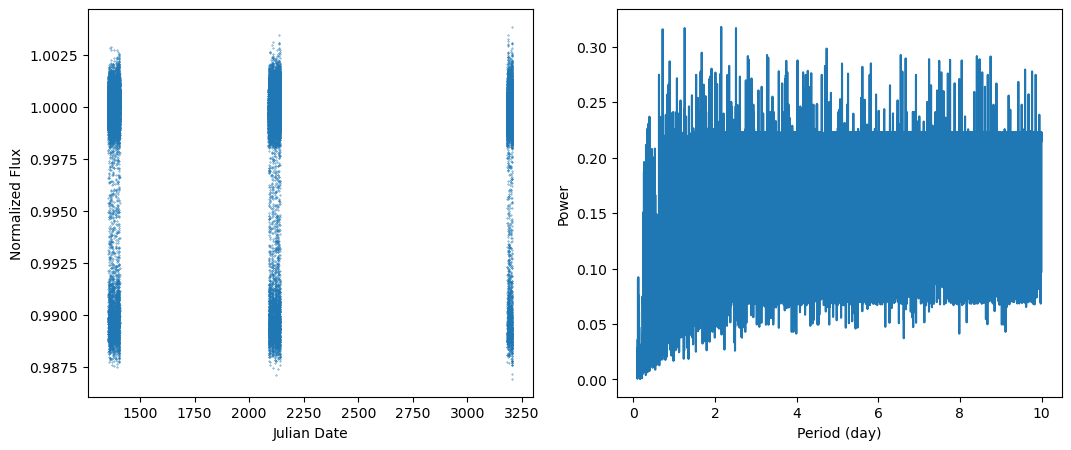

In [36]:
model = BoxLeastSquares(all_trimmed_time * u.day, all_trimmed_flux, dy=0.01)
period = np.linspace(0.1, 10, 10000) *u.day
periodogram = model.power(period, 0.08)
figure, ax = plt.subplots(1, 2)
figure.set_figwidth(11)
figure.set_figheight(5)
figure.tight_layout(pad=3.0)
plt.subplot(1, 2, 2)
plt.plot(periodogram.period,periodogram.power)
plt.xlabel('Period (day)')
plt.ylabel('Power')
plt.subplot(1, 2, 1)
plt.scatter(concate_time, concate_flux, s=0.1)
plt.xlabel('Julian Date')
plt.ylabel('Normalized Flux')

In [ ]:
concate_time = np.array([])
concate_flux = np.array([]) 
for i in range(5): 
    data_file = fits.open(fits_files[i], memmap=True)
    time = data_file[1].data['TIME']
    flux = data_file[1].data['PDCSAP_FLUX']
    quality = data_file[1].data['QUALITY']
    new_flux = np.array([])
    new_time = np.array([])
    for j in range(len(time)):
        if(quality[j] == 0 and np.isnan(flux[j]) == False):
            new_flux = np.append(new_flux, flux[j])
            new_time = np.append(new_time, time[j])
    flux_med = np.median(new_flux)
    if(flux_med == 0 or np.isnan(flux_med) == True):
        print(flux_med)
    new_flux = new_flux/flux_med
    concate_time = np.append(concate_time, new_time)
    concate_flux = np.append(concate_flux, new_flux)
model = BoxLeastSquares(concate_time * u.day, concate_flux, dy=0.01)
period = np.linspace(0.1, 10, 10000) *u.day
periodogram = model.power(period, 0.08)
figure, ax = plt.subplots(1, 2)
figure.set_figwidth(11)
figure.set_figheight(5)
figure.tight_layout(pad=3.0)
plt.subplot(1, 2, 2)
plt.plot(periodogram.period,periodogram.power)
plt.xlabel('Period (day)')
plt.ylabel('Power')
plt.subplot(1, 2, 1)
plt.scatter(concate_time, concate_flux, s=0.1)
plt.xlabel('Julian Date')
plt.ylabel('Normalized Flux')
max_power = np.argmax(periodogram.power)
transitperiod = periodogram.period[max_power].value
transitdepth = periodogram.depth[max_power]
transittime = periodogram.transit_time[max_power].value
transitduration = periodogram.duration[max_power].value

0.9408582895016969
0.9408582895016969
0.9408582895016969
0.9408582895016969
0.9408582895016969


Text(100.09722222222221, 0.5, 'Normalized Flux')

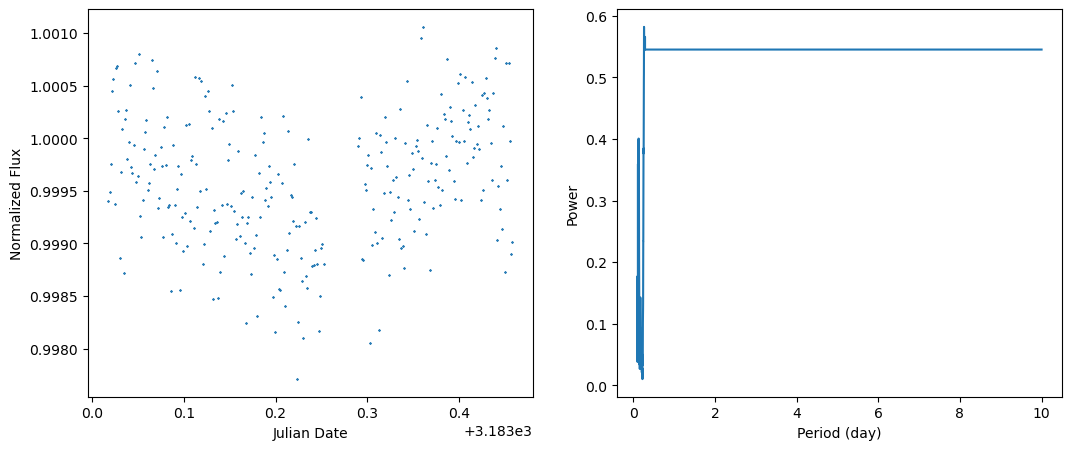

In [32]:
concate_time2 = np.array([])
concate_flux2 = np.array([]) 
for i in range(5): 
    data_file = fits.open(fits_files[i], memmap=True)
    time = data_file[1].data['TIME']
    flux = data_file[1].data['PDCSAP_FLUX']
    quality = data_file[1].data['QUALITY']
    new_flux = np.array([])
    new_time = np.array([])
    for j in range(len(time)):
        if(quality[j] == 0 and np.isnan(flux[j]) == False):
            new_flux = np.append(new_flux, flux[j])
            new_time = np.append(new_time, time[j])
    flux_med = np.median(new_flux)
    if(flux_med == 0 or np.isnan(flux_med) == True):
        print(flux_med)
    new_flux = new_flux/flux_med
    model = BoxLeastSquares(np.array(current_time) * u.day, np.array(current_flux), dy=0.01)
    periodogram = model.autopower(0.05 * u.day, minimum_period=0.1, maximum_period=10, oversample=1000)
    max_power = np.argmax(periodogram.power)
    depth = periodogram.depth[max_power]
    epoch = periodogram.transit_time[max_power].value
    period = periodogram.period[max_power].value
    print(period)
    #period = np.linspace(0.1, 10, 10000) *u.day
    min = epoch +0.25
    max = epoch + period- 0.25
    trimmed_time = []
    trimmed_flux = []
    for i in range(len(current_time)): 
        if(current_time[i] >= min and current_time[i] <= max): 
            trimmed_time.append(current_time[i])
            trimmed_flux.append(current_flux[i])
    for i in range(len(trimmed_time)): 
        concate_time2 = np.append(concate_time2, trimmed_time[i])
        concate_flux2 = np.append(concate_flux2, trimmed_flux[i])

model = BoxLeastSquares(concate_time2 * u.day, concate_flux2, dy=0.01)
period = np.linspace(0.1, 10, 10000) *u.day
periodogram = model.power(period, 0.08)
figure, ax = plt.subplots(1, 2)
figure.set_figwidth(11)
figure.set_figheight(5)
figure.tight_layout(pad=3.0)
plt.subplot(1, 2, 2)
plt.plot(periodogram.period,periodogram.power)
plt.xlabel('Period (day)')
plt.ylabel('Power')
plt.subplot(1, 2, 1)
plt.scatter(concate_time2, concate_flux2, s=0.1)
plt.xlabel('Julian Date')
plt.ylabel('Normalized Flux')

In [54]:
d = 0
for i in range(len(second_depth)): 
    d = d + second_depth[i]
d = d/len(second_depth)


In [72]:
Rs = 1.319 * u.Rsun #stellar radius
Ls = 10**0.428 * u.Lsun #stellar luminosity
radius = radius_planet.to(u.Rsun)
Ts = 6432 * u.K #stellar temperature
temp = (0.0003627879423272686*(Rs/radius)**2 *Ls)**(1/4) * Ts
print('temperature of planet: ', temp)

temperature of planet:  3557.2678252757582 K solLum(1/4)


In [ ]:
period = transit_period.to(u.min) 
num = period/2 #number of data points in one period 
num = num *3 #number of data points in 3 periods


In [64]:
for i in range(len(result_table)):
    phase = phase_fold(result_table['TIME'], 0.94145223, transit_time) 
result_table['PHASE'] = phase

Text(0, 0.5, 'Normalized Flux')

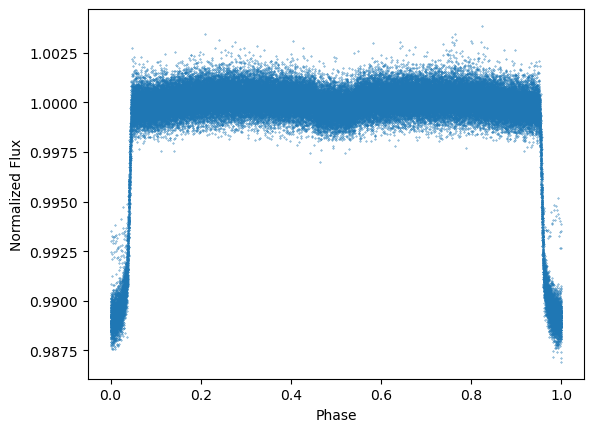

In [65]:
plt.scatter(result_table['PHASE'], result_table['FLUX'], s = 0.1)
plt.xlabel('Phase')
plt.ylabel('Normalized Flux')

In [66]:
def phase_centered(time, period, epoch):
    phase = np.mod(time - epoch - period/2, period)
    return phase

In [312]:
phase = np.mod(result_table['TIME'] - transit_time - transit_period/2, transit_period)

In [67]:
for i in range(len(result_table)):
    phase = phase_centered(result_table['TIME'],0.94145223, transit_time) 
result_table['PHASE CENTERED'] = phase

Text(0, 0.5, 'Normalized Flux')

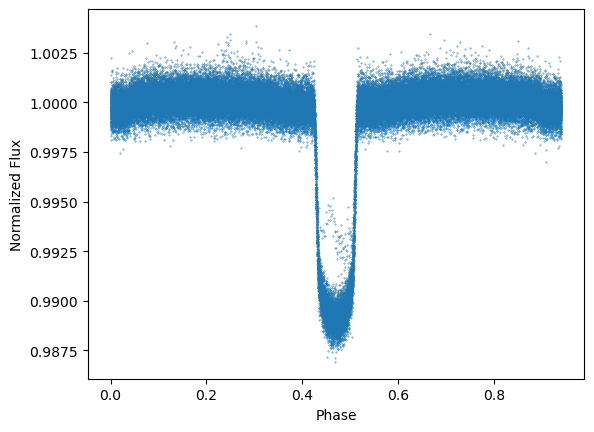

In [68]:
plt.scatter(result_table['PHASE CENTERED'], result_table['FLUX'], s = 0.1)
plt.xlabel('Phase')
plt.ylabel('Normalized Flux')

In [69]:
second_phase = np.array([])
second_flx = np.array([])
for i in range(len(result_table)):
    if(result_table['PHASE'][i] > 0.1 or result_table['PHASE'][i] < 0.9): 
        second_phase = np.append(second_phase, result_table['PHASE'][i])
        second_flx = np.append(second_flx, result_table['FLUX'][i])
model = BoxLeastSquares(second_phase, second_flx, dy=0.01)
periodogram = model.autopower(0.08)
max_power = np.argmax(periodogram.power)
second_period = periodogram.period[max_power]
second_time = periodogram.period[max_power]
second_duration = periodogram.duration[max_power]
second_depth = periodogram.depth[max_power]


In [319]:
max(t_list1)

3206.136060251118

In [320]:
min(t_list2)

1354.1115072617192

In [321]:
min(result_table['TIME'])

1354.1115072617192

In [322]:
min(result_table['TIME']) + 0.94145223

1355.0529594917193

In [61]:
second_phase = np.array([])
second_flx = np.array([])
second_time = np.array([])
for i in range(len(result_table)):
    if(result_table['TIME'][i] >= 1354.6 and result_table['TIME'][i] <=1355.3): 
        second_phase = np.append(second_phase, result_table['PHASE'][i])
        second_flx = np.append(second_flx, result_table['FLUX'][i])
        second_time = np.append(second_time, result_table['TIME'][i])

KeyError: 'PHASE'

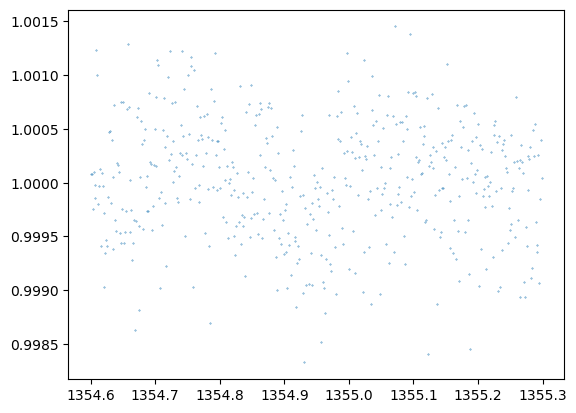

In [406]:
plt.scatter(second_time, second_flx, s = 0.1)

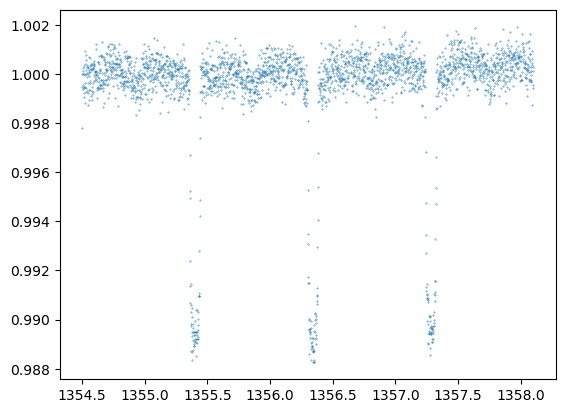

In [371]:
second_phase = np.array([])
second_flx = np.array([])
second_time = np.array([])
for i in range(len(result_table)):
    if(result_table['TIME'][i] >= 1354.5 and result_table['TIME'][i] <=1358.1): 
        second_phase = np.append(second_phase, result_table['PHASE'][i])
        second_flx = np.append(second_flx, result_table['FLUX'][i])
        second_time = np.append(second_time, result_table['TIME'][i])
plt.scatter(second_time, second_flx, s = 0.1)


In [397]:
model = BoxLeastSquares(second_phase, second_flx, dy=0.01)
periodogram = model.autopower(0.08, oversample = 100000)
max_power = np.argmax(periodogram.power)
second_period = periodogram.period[max_power]
second_time = periodogram.period[max_power]
second_duration = periodogram.duration[max_power]
second_depth = periodogram.depth[max_power]

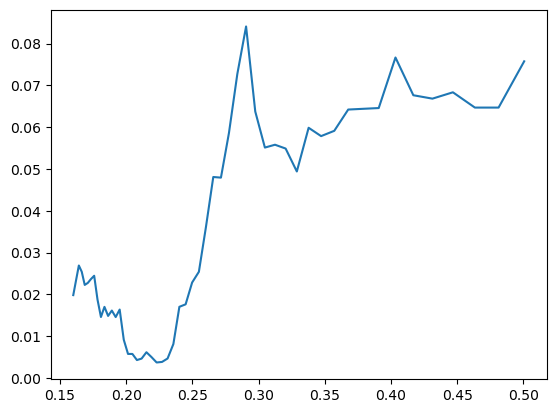

In [401]:
plt.plot(periodogram.period, periodogram.power)

In [372]:
for i in range(len(second_time)):
    phase = phase_centered(second_time, transit_period, transit_time) 

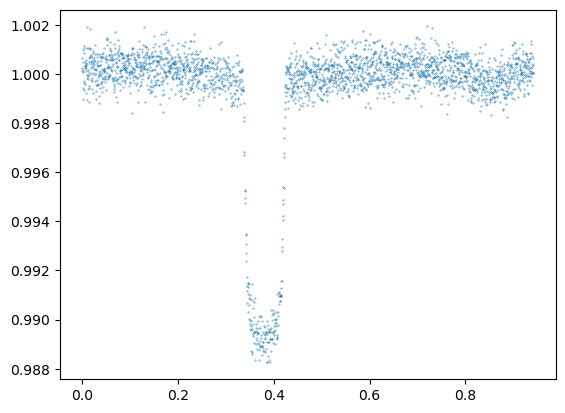

In [378]:
plt.scatter(phase, second_flx, s = 0.1)

In [402]:
#calculate temperature 
Rs = 1.319 * u.Rsun #stellar radius
Ts = 6432 *u.K #stellar temperature
Ls = 10**0.428 * u.Lsun #stellar luminosity
radius = radius_planet.to(u.Rsun)

temp = (second_depth*(Rs.value/radius)**2 * Ls)**(1/4) * Ts
print('temperature: ', temp)

temperature:  3369.9069851520753 K solLum(1/4) / solRad(1/2)


In [201]:
np.min(second_flx)

0.988204836845398

In [202]:
for i in range(len(second_flx)): 
    if(second_flx[i] == 0.988204836845398): 
        print(i)

255


In [203]:
result_table['TIME'][255]

1354.4670733188652

In [204]:
1354.4670733188652 + 0.94145223

1355.4085255488653

In [189]:
len(second_phase)

676

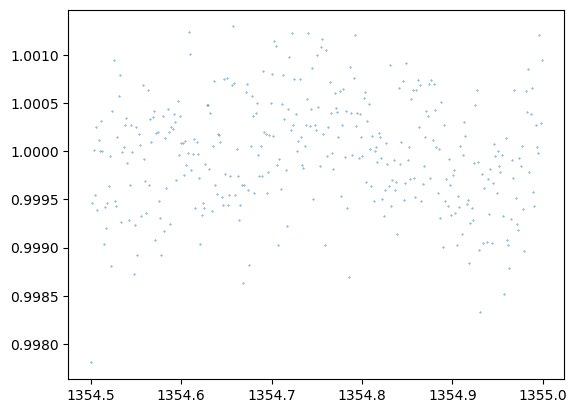

In [220]:
plt.scatter(second_time, second_flx, s = 0.1)

In [250]:
model = BoxLeastSquares(second_phase, second_flx, dy=0.01)
periodogram = model.autopower(0.08)
max_power = np.argmax(periodogram.power)
second_period = periodogram.period[max_power]
second_time = periodogram.period[max_power]
second_duration = periodogram.duration[max_power]
second_depth = periodogram.depth[max_power]

In [251]:
print('second period: ', second_period , '\n', 'second duration: ', second_duration, '\n', 'second depth: ', second_depth, '\n', 'second time: ', second_time)

second period:  0.4149040411480767 
 second duration:  0.08 
 second depth:  0.0003627879423272686 
 second time:  0.4149040411480767


Text(0.5, 1.0, 'Secondary eclipse periodogram')

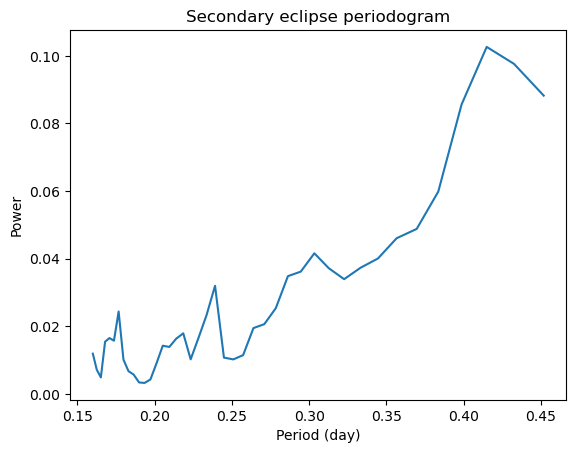

In [252]:
plt.plot(periodogram.period, periodogram.power)
     
plt.xlabel('Period (day)')
plt.ylabel('Power')
plt.title('Secondary eclipse periodogram')


In [167]:
second_phase = np.array([])
second_flx = np.array([])
for i in range(len(result_table)): 
    if(result_table['PHASE CENTERED'][i] < 0.1  or result_table['PHASE CENTERED'][i] > 0.9): 
        second_phase = np.append(second_phase, result_table['PHASE CENTERED'][i])
        second_flx = np.append(second_flx, result_table['FLUX'][i])
model = BoxLeastSquares(second_phase, second_flx, dy=0.01)
periodogram = model.autopower(0.08)
max_power = np.argmax(periodogram.power)
second_period = periodogram.period[max_power]
second_time = periodogram.period[max_power]
second_duration = periodogram.duration[max_power]
second_depth = periodogram.depth[max_power]


In [168]:
print('second period: ', second_period , '\n', 'second duration: ', second_duration, '\n', 'second depth: ', second_depth, '\n', 'second time: ', second_time)

second period:  0.17799440335418873 
 second duration:  0.08 
 second depth:  0.0003415148725893646 
 second time:  0.17799440335418873


In [224]:
sb = 5.67E-8*u.watt/(u.m**2*u.K**4)
s_temp = 6432*u.Kelvin
sLum = np.power(10, 0.428) * u.Lsun 
sLum = sLum.to(u.watt)
pLum = second_depth * sLum #b/c depth = pLum/sLum
T = (pLum/sLum)**(1/4) * s_temp
print(T)



768.1769675435391 K


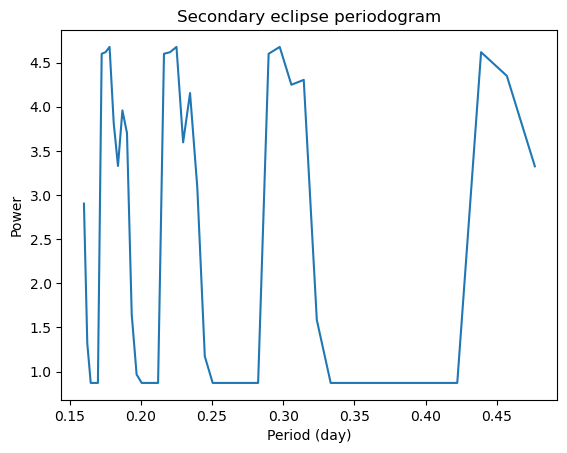

In [90]:
plt.plot(periodogram.period, periodogram.power)
     
plt.xlabel('Period (day)')
plt.ylabel('Power')
plt.title('Secondary eclipse periodogram')

plt.show()

In [ ]:
#epoch = transit_time function for BLS --> replace with this and it should work out 
def primary_transit_phase_fold(time, period, epoch):
    phase = (time-epoch)/period %1
    primary_transit_phase = ((epoch - epoch)/period) %1
    phase = (phase - primary_transit_phase + 0.5*transit_period) %1
    return phase

In [33]:
for i in range(len(result_table)): 
    phase = np.mod(result_table['TIME'] - transit_time - transit_period/2, 0.94145223)
    #phase = phase_fold(result_table['TIME'], 0.94145223, transit_time)

result_table['PHASE'] = phase

KeyboardInterrupt: 

Text(0, 0.5, 'Normalized Flux')

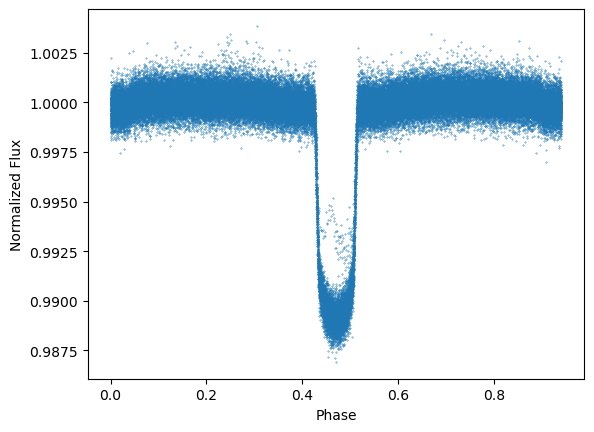

In [32]:
plt.scatter(result_table['PHASE'], result_table['FLUX'], s=0.1)
plt.xlabel('Phase')
plt.ylabel('Normalized Flux')

In [17]:
def phase_fold(time, period, epoch): 
     phase = (time-epoch)/period %1
     return phase

In [19]:
for i in range(5):
     hdu_list = fits.open(fits_file, memmap=True) 
     data = Table(hdu_list[1].data)
     if(data['QUALITY'] != 0 and np.isnan(data['PDCSAP_FLUX'])): 

In [1]:
#epoch = transit_time function for BLS --> replace with this and it should work out 
def primary_transit_phase_fold(time, period, epoch):
    phase = (time-epoch)/period %1
    primary_transit_phase = ((epoch - epoch)/period) %1
    phase = (phase - primary_transit_phase + 0.5*transit_period) %1
    return phase

In [10]:
for i in range(len(result_table)): 
    #phase = primary_transit_phase_fold(result_table['TIME'], transit_period, transit_time)
    phase = np.mod(result_table['TIME'] - transit_time - transit_period/2, transit_period)

result_table['PHASE_CENTERED'] = phase

Text(0, 0.5, 'Normalized Flux')

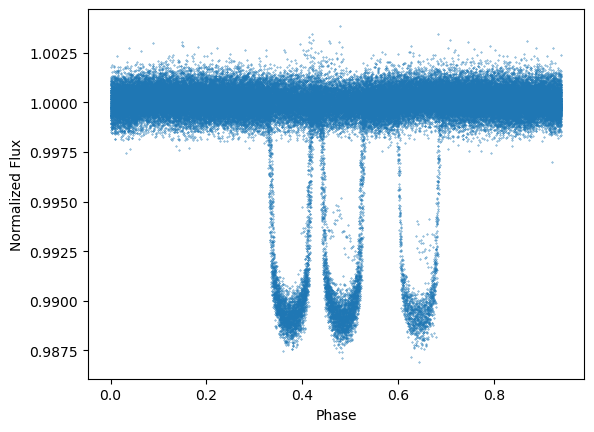

In [11]:
plt.scatter(result_table['PHASE_CENTERED'], result_table['FLUX'], s=0.1)
plt.xlabel('Phase')
plt.ylabel('Normalized Flux')